In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_score, recall_score, precision_recall_curve, recall_score, plot_roc_curve)

import warnings
warnings.filterwarnings('ignore')

## 0. Загрузка данных

In [2]:
df = pd.read_csv('../content/Loan_Data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 1. Базовое решение

### 1.1 Удаление пропущенных значений

In [3]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
# все-таки посчитаем переменную 'Depndents' за вещественную
df.loc[df['Dependents'] == '3+', 'Dependents'] = 4

In [5]:
num_features = ['Dependents', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

from sklearn.impute import SimpleImputer

si_med = SimpleImputer(strategy='median')
si_med.fit(df[num_features])

# si_med.statistics_

SimpleImputer(strategy='median')

In [6]:
df[num_features] = si_med.transform(df[num_features])
df[num_features].isna().sum()

Dependents          0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64

### 1.2 Удаление всех категориальных переменных (и не имеющих информационной ценности)

In [7]:
df.drop(columns=
        ['Loan_ID', 'Gender', 'Married'
         , 'Education', 'Self_Employed', 'Property_Area']
         , inplace=True)
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,0.0,5849,0.0,128.0,360.0,1.0,Y
1,1.0,4583,1508.0,128.0,360.0,1.0,N
2,0.0,3000,0.0,66.0,360.0,1.0,Y
3,0.0,2583,2358.0,120.0,360.0,1.0,Y
4,0.0,6000,0.0,141.0,360.0,1.0,Y


In [8]:
# преобразуем метки целевого признака в числовые значения

df.loc[df['Loan_Status'] == 'Y', 'Loan_Status'] = 1
df.loc[df['Loan_Status'] == 'N', 'Loan_Status'] = 0
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,0.0,5849,0.0,128.0,360.0,1.0,1
1,1.0,4583,1508.0,128.0,360.0,1.0,0
2,0.0,3000,0.0,66.0,360.0,1.0,1
3,0.0,2583,2358.0,120.0,360.0,1.0,1
4,0.0,6000,0.0,141.0,360.0,1.0,1


### 1.3 Обучение модели

In [9]:
X = df.drop(columns='Loan_Status')
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,             # применим из-за дисбаланса классов
                                                    random_state=42)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

X_train.shape, X_test.shape

((491, 6), (123, 6))

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [11]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

# pred_proba_test = lr.predict_proba(X_test)

### 1.4 Подсчет метрик качества

In [12]:
# для train'а
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.91      0.40      0.56       154
           1       0.78      0.98      0.87       337

    accuracy                           0.80       491
   macro avg       0.85      0.69      0.71       491
weighted avg       0.82      0.80      0.77       491



In [13]:
# для test'а
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



<Figure size 1200x1200 with 0 Axes>

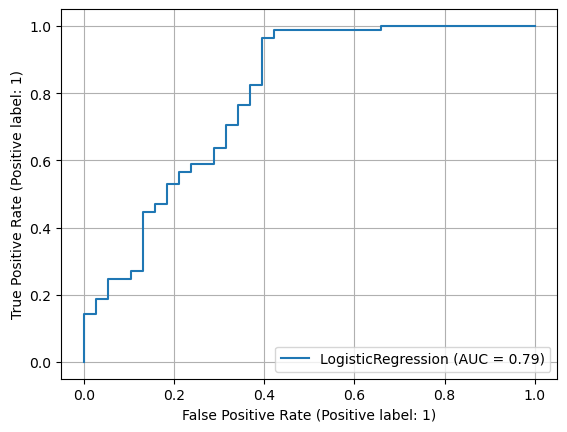

In [14]:
plt.figure(figsize=(12, 12))
plot_roc_curve(lr, X_test, y_test)
plt.grid(True)

**Выводы по базовому решению**:

Гармоническое среднее ($F^2$-мера) на `test`'е получилось равным 0.81 (для макроусреднения, потому как имеется дисбаланс классов). Метрика `ROC-AUC` = 0.79

## 2. Первыичный анализ данных

In [15]:
df = pd.read_csv('../content/Loan_Data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
